In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================
# -- Copied from lecture
%load_ext autoreload
%config IPCompleter.greedy=True
%autoreload 1
%aimport util
import logging
import os
import random

import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from keras import layers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

from util import util

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

# Set random seed
os.environ['PYTHONHASHSEED'] = '0'
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Preprocess config
preprocess_clean = [util.impute_missing_values, util.apply_detrending, util.impute_anomalies]
preprocess = [util.impute_missing_values, util.apply_detrending]

# Load datasets
X_train_clean, y_train_clean = util.load_dataset_xy('7_gecco2019_train_water_quality.csv', preprocess=preprocess_clean)
X_train, y_train = util.load_dataset_xy('7_gecco2019_train_water_quality.csv', preprocess=preprocess)
X_val_clean, y_val_clean = util.load_dataset_xy('8_gecco2019_valid_water_quality.csv', preprocess=preprocess_clean)
X_val, y_val = util.load_dataset_xy('8_gecco2019_valid_water_quality.csv', preprocess=preprocess)
X_test, y_test = util.load_dataset_xy('6_gecco2019_test_water_quality.csv', preprocess=preprocess)

# Get feature columns
feature_columns = util.get_feature_columns(X_train)

# Standardize features
scaler = StandardScaler()
X_train_clean[feature_columns] = scaler.fit_transform(X_train_clean[feature_columns])
X_train[feature_columns] = scaler.transform(X_train[feature_columns])
X_val_clean[feature_columns] = scaler.transform(X_val_clean[feature_columns])
X_val[feature_columns] = scaler.transform(X_val[feature_columns])
X_test[feature_columns] = scaler.transform(X_test[feature_columns])

# Autoencoder for Anomaly Detection
Another approach to anomaly detection is to use an autoencoder. Autoencoders are a type of neural network that are trained to reconstruct the input data. Internally, the autoencoder consists of an encoder and a decoder. The encoder maps the input data to a lower-dimensional representation, while the decoder reconstructs the original input from the encoded representation. The autoencoder is trained to minimize the reconstruction error between the input and the reconstructed output.

One important aspect is, that the data we use for training the autoencoder should be free from anomalies. This is because the autoencoder is trained to reconstruct the input data, and anomalies can distort the reconstruction. Therefore, we need to preprocess the data before training the autoencoder.

Furthermore, for neural networks it is crucial that we train on standardized data due to the use of gradient descent.

<center>
    <img src="assets/ae.png" width=50%/>
</center>

## Building the Neural Network
The Keras API is quite handy for building neural networks. The architecture is quite similar to what we have seen in the lectures. However, we added four additional hidden layers with 64 neurons each. This helps the model to learn more complex representations of the input data. We obtained the best results with a latent space of 3 dimensions.

In [2]:
inputs = X_train.shape[1]
input_shape = (inputs, )
ae_x = keras.Input(shape=input_shape, dtype='float32')
x = ae_x
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
ae_z = layers.Dense(3, activation='relu')(x)
x = layers.Dense(64, activation='relu')(ae_z)
x = layers.Dense(64, activation='relu')(x)
ae_y = layers.Dense(inputs, activation='linear')(x)
ae = keras.Model(ae_x, ae_y)

ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,609 (37.54 KB)

 Trainable params: 9,609 (37.54 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Neural Network
Training the autoencoder is quite straightforward. We simply need to compile the model, define the optimizer and loss function, and train it using the training data. For the learning rate we picked 1e-4. The model will be trained for 30 epochs, with a batch size of 16. The training process will be monitored using the MSE loss.

Epoch 1/30
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 5s 576us/step - loss: 0.4339 - val_loss: 1.6391
Epoch 2/30
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 5s 563us/step - loss: 0.0915 - val_loss: 0.4182
Epoch 3/30
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 5s 559us/step - loss: 0.0676 - val_loss: 0.3397
Epoch 4/30
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 5s 561us/step - loss: 0.0580 - val_loss: 0.3410
Epoch 5/30
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 5s 557us/step - loss: 0.0525 - val_loss: 0.3419
Epoch 6/30
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 5s 560us/step - loss: 0.0485 - val_loss: 0.3408
Epoch 7/30
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 5s 569us/step - loss: 0.0443 - val_loss: 0.3420
Epoch 8/30
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 5s 558us/step - loss: 0.0466 - val_loss: 0.3256
Epoch 9/30
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 5s 559us/step - loss: 0.0461 - val_loss: 0.3737
Epoch 10/30
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 5s 558us/step - loss: 0.0424 - val_loss: 0.3232
Epoch 11/30
8280/8280 ━━━━━━━━━━━━━━━━━━━━ 5s 558us/step - loss: 0.0421 - val_loss: 0.3292
Epoch 12

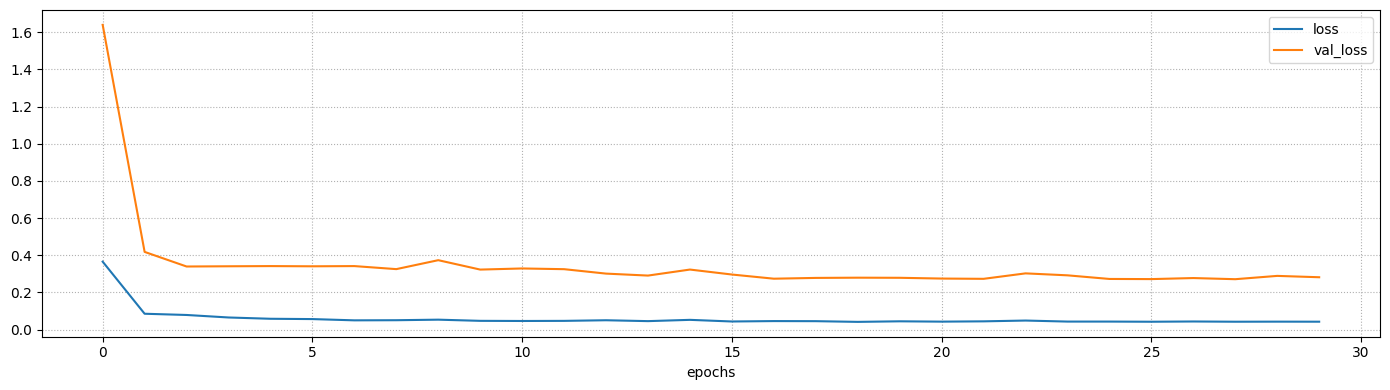

Final scores: loss: 0.0430, val_loss: 0.2820


In [3]:
# Compute sample weights
class_proportions = y_train.value_counts(normalize=True)
sample_weights = y_train.map(class_proportions).values

# Train the model
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
cb = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history = ae.fit(X_train_clean, X_train_clean, validation_data=(X_val_clean, X_val_clean), sample_weight=sample_weights, callbacks=cb, batch_size=16, epochs=30, verbose=1)

# Plot training history
util.plot_training_history(history, figsize=figsize)

## Threshold Optimization
Now, we need to define a threshold to separate normal data from anomalous data. We will use a simple threshold optimization approach using the validation set. First, we define the percentiles to test. Then, we compute precision, recall, and F1-score for each percentile. These are the preferred metrics when working with big class imbalances. Finally, we select the percentile with the highest F1-score.

1711/1711 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


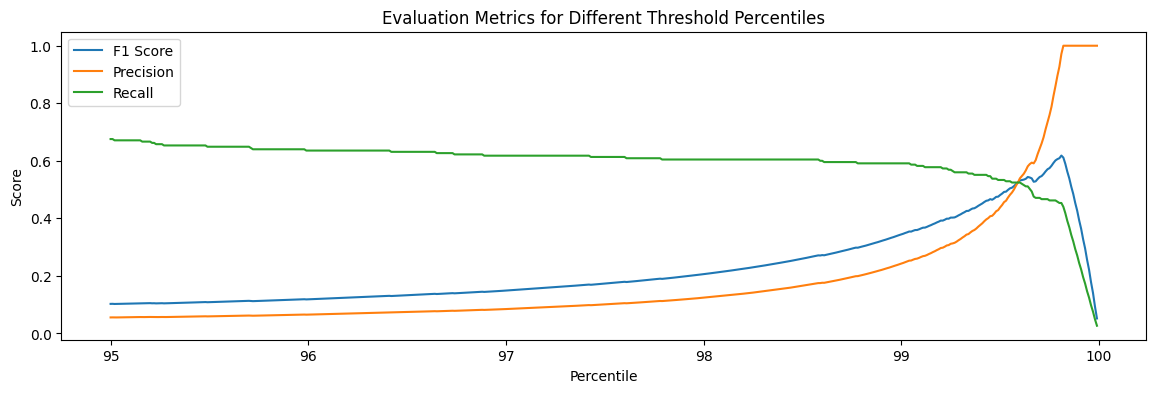

Best threshold based on F1 score:
Percentile: 99.81000000000246, Threshold: 167.7736, F1: 0.6182, Precision: 0.9714, Recall: 0.4533


In [4]:
# Compute reconstruction errors for the validation data
X_val_pred = ae.predict(X_val)
reconstruction_errors = np.mean(np.square(X_val - X_val_pred), axis=1)

# Let's test percentiles from 95th to 100th percentile in steps of 0.01.
percentile_range = np.arange(95, 100, 0.01)  # Testing thresholds from the 80th to 99th percentile
results = []

for percentile in percentile_range:
    y_pred, threshold = util.get_predictions_from_reconstruction_errors(reconstruction_errors, percentile)

    # Compute evaluation metrics
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    results.append((percentile, threshold, f1, precision, recall))

# Plot metrics vs percentiles for visualization
percentiles = [r[0] for r in results]
f1_scores = [r[2] for r in results]
precisions = [r[3] for r in results]
recalls = [r[4] for r in results]

plt.figure(figsize=figsize)
plt.plot(percentiles, f1_scores, label='F1 Score')
plt.plot(percentiles, precisions, label='Precision')
plt.plot(percentiles, recalls, label='Recall')
plt.xlabel("Percentile")
plt.ylabel("Score")
plt.title("Evaluation Metrics for Different Threshold Percentiles")
plt.legend()
plt.show()

# Select the best threshold based on the maximum F1 score
best = max(results, key=lambda x: x[2])
print("Best threshold based on F1 score:")
print(f"Percentile: {best[0]}, Threshold: {best[1]:.4f}, F1: {best[2]:.4f}, Precision: {best[3]:.4f}, Recall: {best[4]:.4f}")

## Evaluation on the Training Data
We can now can evaluate its performance on the training data. We will again investigate the confusion matrix and the classification report.

In [5]:
# Compute likelihood scores for the training data.
X_train_pred = ae.predict(X_train)
reconstruction_errors = np.mean(np.square(X_train - X_train_pred), axis=1)
y_pred_train, threshold_train = util.get_predictions_from_reconstruction_errors(reconstruction_errors, best[0])

# Print threshold
print(f'Ideal threshold: {threshold_train:.2f}')

# Print performance metrics
print('Confusion Matrix:\n', confusion_matrix(y_train, y_pred_train))
print('Classification Report:\n', classification_report(y_train, y_pred_train))

4140/4140 ━━━━━━━━━━━━━━━━━━━━ 1s 229us/step
Ideal threshold: 0.60
Confusion Matrix:
 [[132141    127]
 [    87    125]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00    132268
        True       0.50      0.59      0.54       212

    accuracy                           1.00    132480
   macro avg       0.75      0.79      0.77    132480
weighted avg       1.00      1.00      1.00    132480



The evaluation on the training data highlights a typical trade-off encountered in imbalanced anomaly detection tasks. The autoencoder demonstrates good performance in correctly classifying the majority class, with almost perfect precision and recall for normal instances. However, its performance on anomalies is less robust, as reflected by a precision of 0.50 and a recall of 0.59 for the anomalous class. This indicates that while the model rarely misclassifies normal cases, it misses a significant proportion of actual anomalies and occasionally mislabels normal instances as anomalies.

## Evaluation on the Test Data
Much more interesting, however, is the performance on the test data.

In [6]:
# Compute likelihood scores for the training data.
X_test_pred = ae.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - X_test_pred), axis=1)
y_pred_test, threshold_test = util.get_predictions_from_reconstruction_errors(reconstruction_errors, best[0])

# Print performance metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

990/990 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
Confusion Matrix:
 [[31458     1]
 [  131    60]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     31459
        True       0.98      0.31      0.48       191

    accuracy                           1.00     31650
   macro avg       0.99      0.66      0.74     31650
weighted avg       1.00      1.00      0.99     31650



On the test set, the model continues to classify the majority class flawlessly, but its performance on anomalies worsens compared to the previous results. While the earlier evaluation yielded a moderate balance with a recall of 0.59 and an f1-score of 0.54 for anomalies, the test results show a precision of 0.98 but a recall that drops to 0.31, resulting in an F1-score of 0.48. This indicates that although the model becomes more conservative on unseen data it misses a larger proportion of actual anomalies.

## Multiple Signal Analysis
Finally, we can investigate the multiple signal analysis. This is a technique that allows us to identify the individual contributions of each feature to the anomaly score. In this case, we will look at the contribution of each feature to the anomaly score for the entire dataset.

This analysis reveals that the model struggles the most to properly reconstruct the `SAC` feature.

6840/6840 ━━━━━━━━━━━━━━━━━━━━ 1s 201us/step


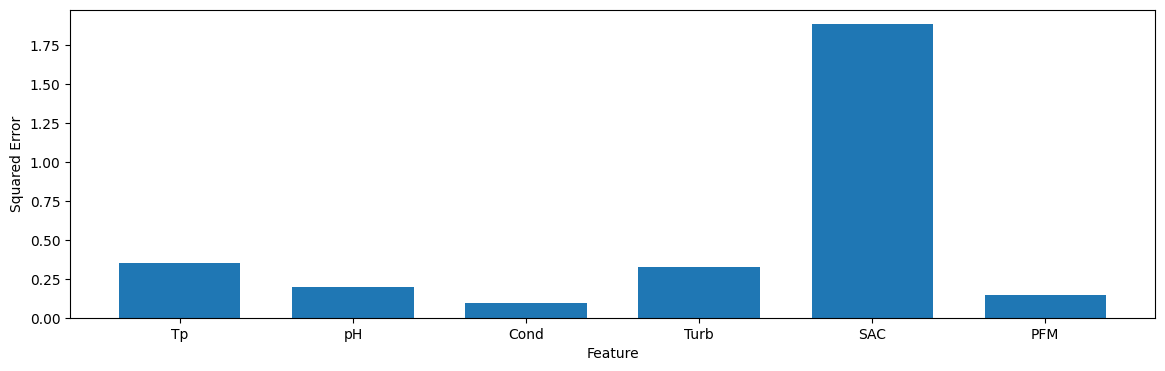

In [7]:
# Load the dataset
X_all, y_all = util.load_dataset_xy('5_gecco2019_all_water_quality.csv', preprocess=preprocess)

# Standardize features
X_all[feature_columns] = scaler.transform(X_all[feature_columns])

# Reconstruct data and compute squared errors
X_pred = ae.predict(X_all)
squared_errors = np.square(X_all - X_pred).mean()
errors_df = pd.Series(index=feature_columns, data=squared_errors)

# Plot the errors per feature
util.plot_bars(errors_df, figsize=figsize, xlabel='Feature', ylabel='Squared Error')